# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit",
                                        target_folder="lectures_batches")

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [59]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model = artm.ARTM(num_topics=T, cache_theta=True, topic_names=topic_names, class_ids={"text":1, "author":1})

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [60]:
# Ваш код
dictionary = artm.Dictionary("dictionary")

In [61]:
dictionary.gather(batch_vectorizer.data_path)

In [62]:
model.seed=1
model.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [63]:
# Ваш код
model.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [64]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothBCG', tau=1e5, dictionary="dictionary", topic_names="bcg", class_ids="text"))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [65]:
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [66]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='Sparse_reg', tau=-1e5, dictionary="dictionary", topic_names=set(topic_names) - set(['bcg']), class_ids="text"))

Выполните еще 15 проходов по коллекции.

In [67]:
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [68]:
# Ваш код
for topic_name in model.topic_names:
    print(topic_name + ': ', end=" ")
    tokens = model.score_tracker["top_words_text"].last_tokens
    if tokens.get(topic_name):
        for word in tokens[topic_name]:    
            print(word, end=" ")
    print()

sbj0:  частица энергия взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя заряд протон масса бозон ускоритель 
sbj1:  материал температура структура химический вещество соединение поверхность свойство химия молекула давление углерод сверхпроводимость металл полимер 
sbj2:  политический государство власть царь партия церковь народ правитель император средневековый враг сага шмитт государь папа 
sbj3:  знание социология социологический познание школа предмет социолог факультет виктор аргумент концепт кафедра логика высказывание прикладной 
sbj4:  мозг нейрон мышление предложение категория чтение взрослый синтаксический синтаксис лицо обезьяна детство шимпанзе библиотека игрушка 
sbj5:  бог миф греческий герой мифология религия душа ритуал грек море мифологический гусейнов божество культ шумерский 
sbj6:  русский слово текст словарь перевод корпус гласный согласный говор немецкий древнерусский академия цитата произносить издание 
sbj7:  раса трудность африка п

In [69]:
# Ваш код
for topic_name in model.topic_names:
    print(topic_name + ': ', end=" ")
    tokens = model.score_tracker["top_words_author"].last_tokens
    if tokens.get(topic_name):
        for word in tokens[topic_name]:    
            print(word, end=" ")
    print()

sbj0:  Дмитрий_Казаков Михаил_Данилов Виктор_Брагута Сергей_Майоров Павел_Пахлов Лев_Дудко Сергей_Троицкий Лев_Беклемишев Анатолий_Лиходед Эдуард_Боос Игорь_Волобуев Валерий_Рубаков Дэвид_Гросс Жан-Арыс_Джилкибаев Аркадий_Цейтлин 
sbj1:  Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Евгений_Гудилин Владимир_Пудалов Иван_Сорокин Дмитрий_Гольберг Валентин_Крапошин Алексей_Хохлов Дмитрий_Клинов Сергей_Морозов Евгений_Антипов Вадим_Бражкин Владимир_Комлев 
sbj2:  Александр_Марей Кирилл_Мартынов Алексей_Юдин Михаил_Бойцов Александр_Павлов Фёдор_Успенский Иван_Ладынин Дина_Гусейнова Рафаэль_Арутюнян Ольга_Тогоева Александр_Воеводский Юрий_Рогулёв Владимир_Малахов Владимир_Петрухин Руслан_Хестанов 
sbj3:  Виктор_Вахштайн Андрей_Лукашов Максим_Демин Татьяна_Клячко Борис_Миркин Алексей_Котов Дмитрий_Балалыкин Сергей_Зенкин Татьяна_Котова Максим_Кронгауз Владимир_Миронов Ян_Левченко Алексей_Рубцов Александр_Филиппов Михаил_Маяцкий 
sbj4:  Филипп_Хайтович Владимир_Спиридонов Наде

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [444]:
sbj_topic_labels = ["Физика элементарных частиц", "Материалы", "Устройство государства", "Социология", "Мозг", "Мифология", "Русский язык", "Раса", 
                    "Юриспроденция", "Заболевания", "Изучение природы", "Психология", "История России", "Наука", 
                    "Галактика", "Экономика", "Отношения", "Компьютерная тематика", "История Азии", "Биология", "Квантовая физика", 
                    "Культура и философия", "Реформы и революция", "2 мировая", "Лингвистика", "Математика", 
                    "Театр", "Вселенная", "Кино"]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [74]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model.get_phi(class_ids="author")
theta = model.get_theta()

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

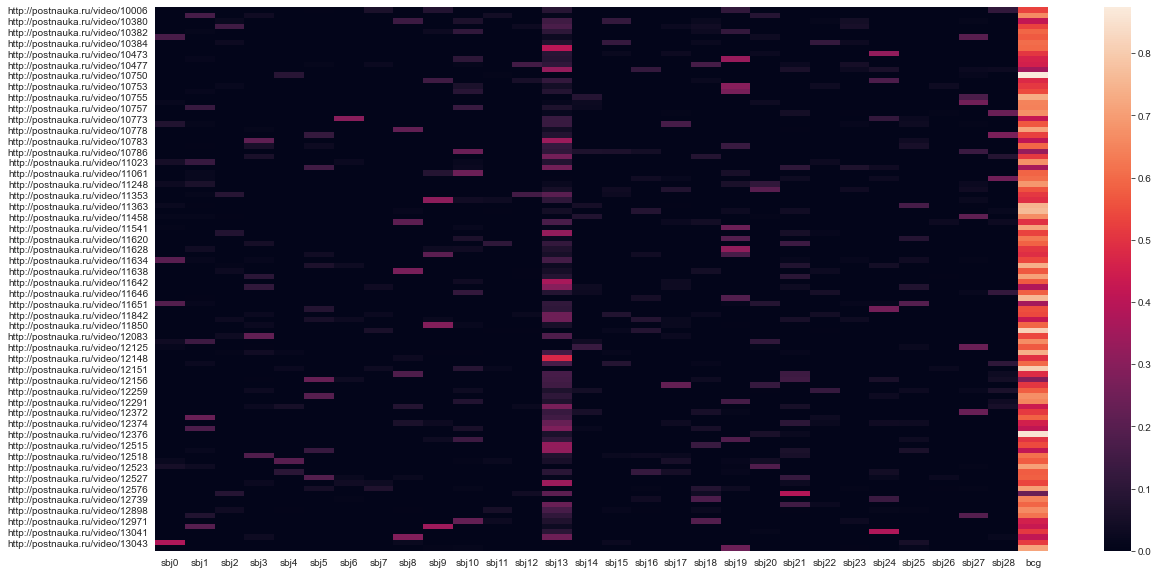

In [75]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.T.head(100));

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [111]:
# Ваш код
theta_sum = theta.sum(axis=1) / theta.sum(axis=1).sum()
theta_sum.index = topic_labels
theta_prob = pd.DataFrame(theta_sum, columns=["Вероятность"])

In [132]:
theta_prob.sort_values(by="Вероятность", ascending=False).iloc[2:7].index

Index(['Биология', 'Квантовая физика', 'Культура и философия',
       'Изучение природы', 'Материалы'],
      dtype='object')

In [133]:
theta_prob.sort_values(by="Вероятность", ascending=True).iloc[:3].index

Index(['Театр', 'Раса', 'Кино'], dtype='object')

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

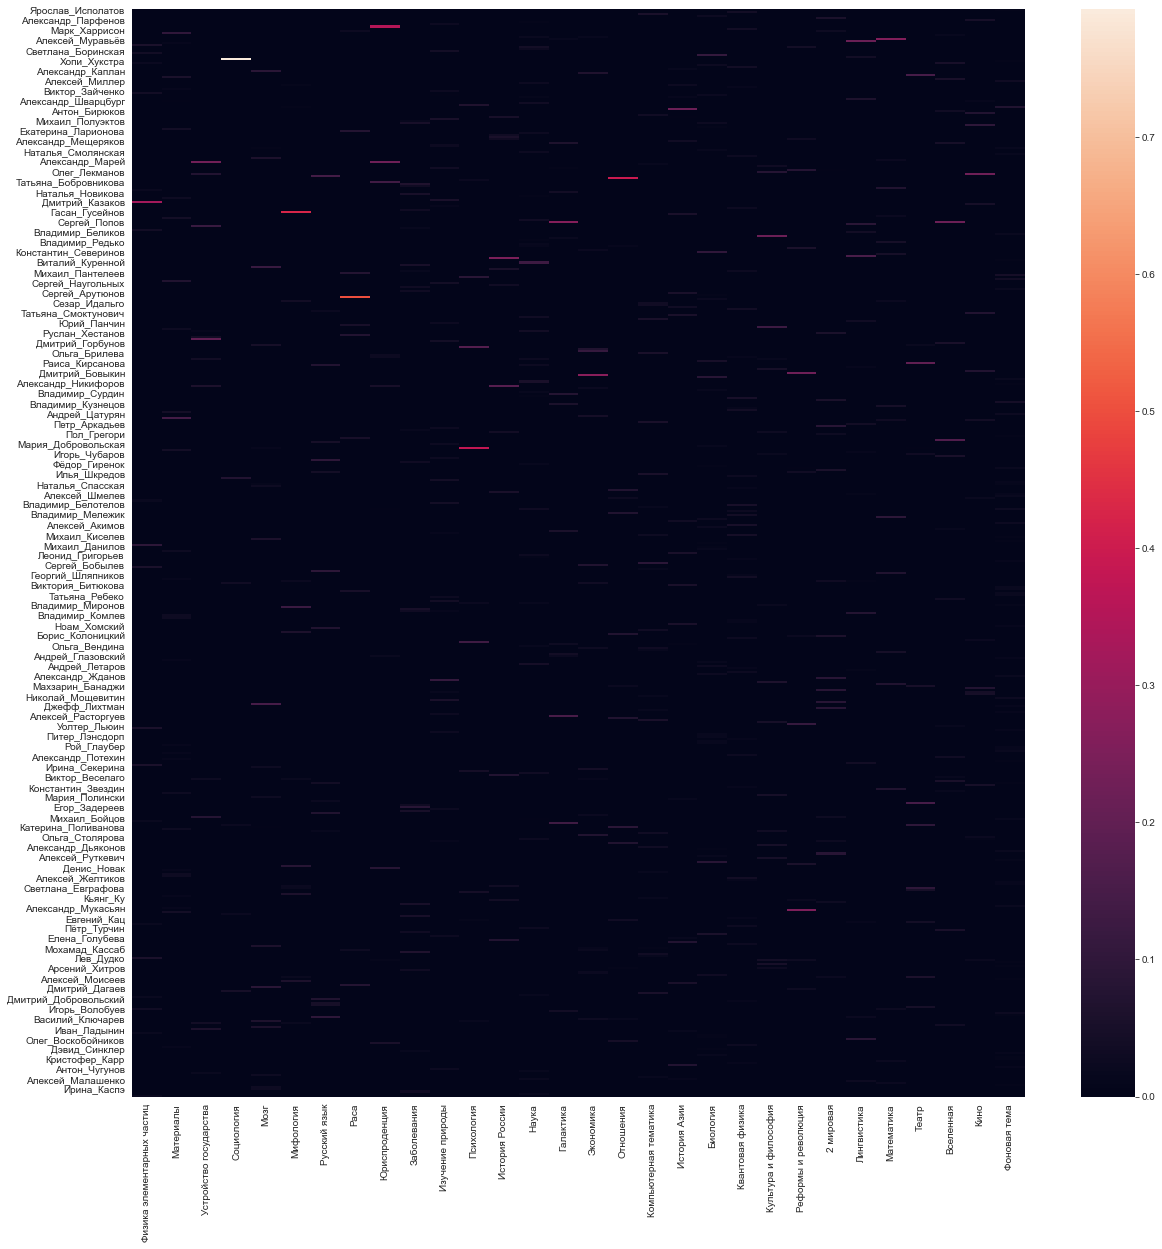

In [140]:
# Ваш код
phi_a.columns = topic_labels
plt.figure(figsize=(20, 20))
seaborn.heatmap(phi_a);

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [149]:
(phi_a > .01).sum(axis=1).sort_values(ascending=False)

Ольга_Вайнштейн         4
Фёдор_Успенский         3
Андрей_Журавлев         3
Дина_Гусейнова          3
Александр_Воеводский    3
Екатерина_Щербакова     2
Андрей_Глазовский       2
Петр_Федичев            2
Александр_Тормасов      2
Алексей_Шмелев          2
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [152]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [261]:
chisl = phi_a.T * theta_prob.values

In [262]:
pta = chisl / chisl.sum(axis=0)

In [263]:
# Ваш код
data_pairwise = pairwise_distances(pta.T, metric="cosine")
pta_mds = MDS(n_components=2, n_jobs=-1, dissimilarity="precomputed").fit_transform(data_pairwise)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

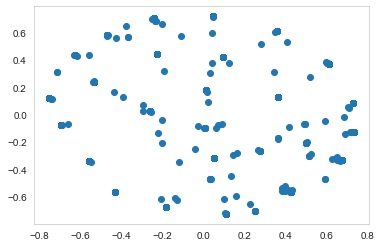

In [264]:
plt.scatter(pta_mds[:, 0], pta_mds[:, 1]);

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

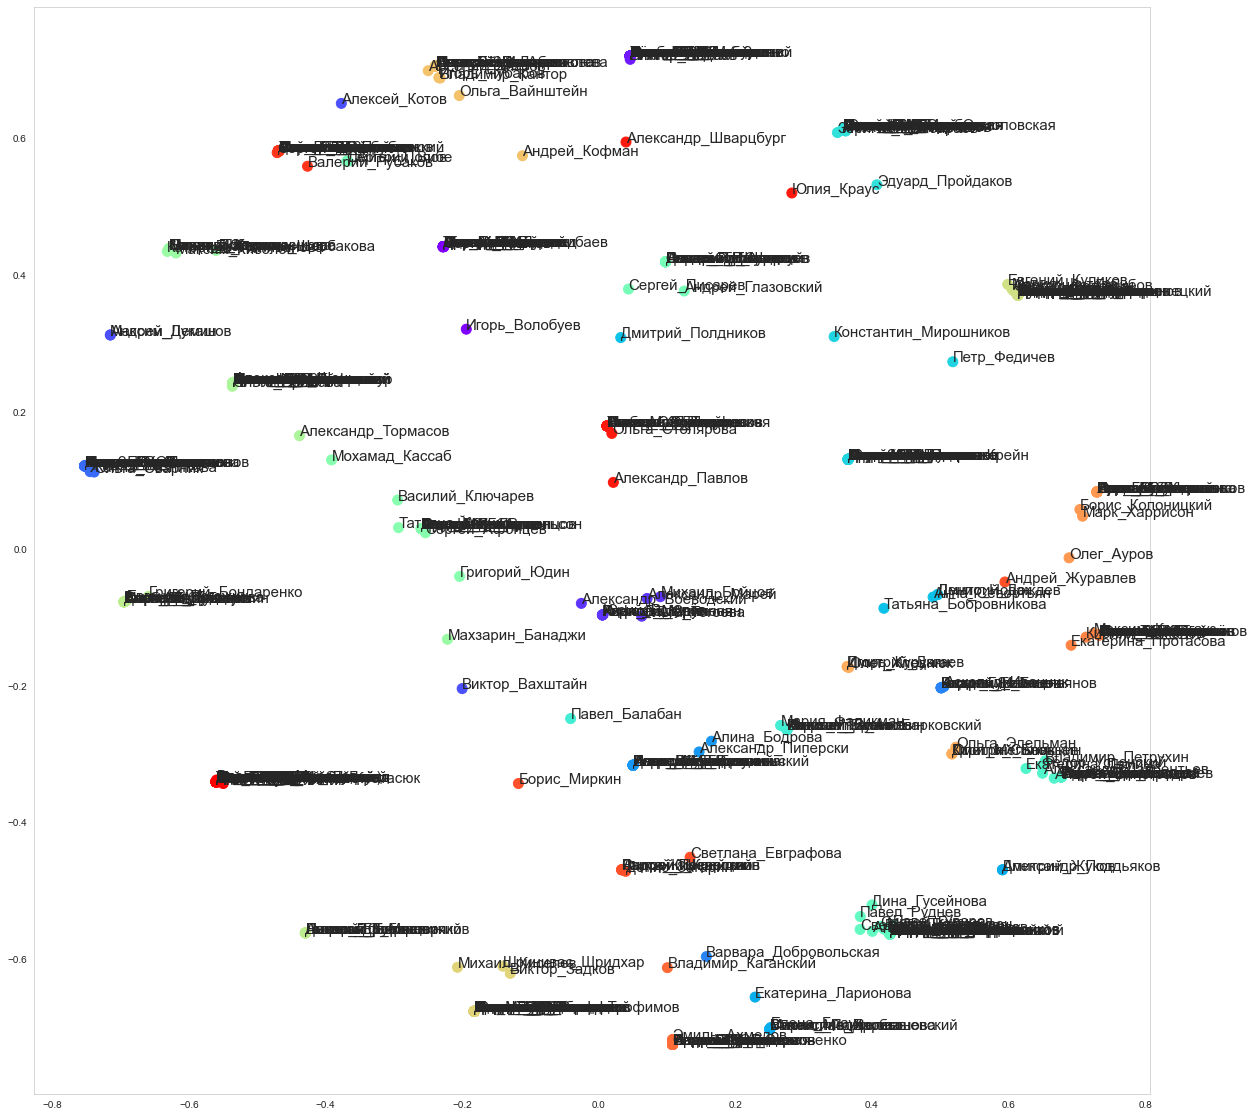

In [375]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T))
pta_c = pta.copy()
pta_c.index = range(T)
max_t = pta_c.idxmax(axis=0)
plt.figure(figsize=[20, 20])
plt.scatter(pta_mds[:, 0], pta_mds[:, 1], c=colors[max_t.values], s=100);
for n, v in zip(pta.T.index, pta_mds):
    plt.annotate(n, xy=v, fontsize = 15, xytext=v)
    
plt.savefig("pta.pdf")

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [433]:
theta.index = topic_labels
pdt = theta.T / theta.sum(axis=1)
artsort_pdt = pdt.values.argsort(axis=0)[::-1]

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [396]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [397]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [459]:
# Ваш код

for i, _ in enumerate(model.topic_names):
    display(HTML(u"<h1>Тема: " + pdt.columns[i] + "</h1>"))
    display(HTML(u"<h2>Топ слов: </h2>"))
    tokens = model.score_tracker["top_words_text"].last_tokens
    for word in tokens[model.topic_names[i]][:10]:    
        display(HTML(u"<ul><li>" + word + "</li></ul>"))
    display(HTML(u"<h2>Топ ссылок по теме: </h2>"))
    for sort_link in artsort_pdt.T[i][:10]:
        print(pdt.index[sort_link])
    print("\n")

http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/18873
http://postnauka.ru/video/47950
http://postnauka.ru/video/18865
http://postnauka.ru/video/2945
http://postnauka.ru/video/47826
http://postnauka.ru/video/1894
http://postnauka.ru/video/47175
http://postnauka.ru/video/14282




http://postnauka.ru/video/13700
http://postnauka.ru/video/31182
http://postnauka.ru/video/18048
http://postnauka.ru/video/57995
http://postnauka.ru/video/41686
http://postnauka.ru/video/13544
http://postnauka.ru/video/51490
http://postnauka.ru/video/46379
http://postnauka.ru/video/31682
http://postnauka.ru/video/56295




http://postnauka.ru/video/9968
http://postnauka.ru/video/28942
http://postnauka.ru/video/31677
http://postnauka.ru/video/23472
http://postnauka.ru/video/16824
http://postnauka.ru/video/32906
http://postnauka.ru/video/25261
http://postnauka.ru/video/5633
http://postnauka.ru/video/42087
http://postnauka.ru/video/42088




http://postnauka.ru/video/20720
http://postnauka.ru/video/434
http://postnauka.ru/video/6380
http://postnauka.ru/video/7731
http://postnauka.ru/video/12083
http://postnauka.ru/video/10783
http://postnauka.ru/video/6725
http://postnauka.ru/video/23361
http://postnauka.ru/video/51350
http://postnauka.ru/video/14295




http://postnauka.ru/video/50793
http://postnauka.ru/video/7068
http://postnauka.ru/video/55068
http://postnauka.ru/video/12521
http://postnauka.ru/video/26207
http://postnauka.ru/video/47548
http://postnauka.ru/video/36350
http://postnauka.ru/video/25891
http://postnauka.ru/video/7767
http://postnauka.ru/video/41350




http://postnauka.ru/video/9997
http://postnauka.ru/video/43664
http://postnauka.ru/video/12156
http://postnauka.ru/video/5999
http://postnauka.ru/video/47300
http://postnauka.ru/video/9992
http://postnauka.ru/video/31990
http://postnauka.ru/video/42796
http://postnauka.ru/video/46427
http://postnauka.ru/video/12290




http://postnauka.ru/video/10773
http://postnauka.ru/video/51171
http://postnauka.ru/video/8964
http://postnauka.ru/video/40001
http://postnauka.ru/video/48114
http://postnauka.ru/video/41689
http://postnauka.ru/video/48112
http://postnauka.ru/video/3379
http://postnauka.ru/video/36272
http://postnauka.ru/video/53453




http://postnauka.ru/video/17397
http://postnauka.ru/video/31707
http://postnauka.ru/video/37732
http://postnauka.ru/video/32898
http://postnauka.ru/video/15341
http://postnauka.ru/video/35150
http://postnauka.ru/video/42707
http://postnauka.ru/video/42735
http://postnauka.ru/video/40880
http://postnauka.ru/video/31675




http://postnauka.ru/video/9299
http://postnauka.ru/video/31688
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/42221
http://postnauka.ru/video/17912
http://postnauka.ru/video/16822
http://postnauka.ru/video/13042
http://postnauka.ru/video/31666




http://postnauka.ru/video/13746
http://postnauka.ru/video/12974
http://postnauka.ru/video/7753
http://postnauka.ru/video/2541
http://postnauka.ru/video/532
http://postnauka.ru/video/11361
http://postnauka.ru/video/57657
http://postnauka.ru/video/49206
http://postnauka.ru/video/11850
http://postnauka.ru/video/45961




http://postnauka.ru/video/2531
http://postnauka.ru/video/9861
http://postnauka.ru/video/7113
http://postnauka.ru/video/8953
http://postnauka.ru/video/30673
http://postnauka.ru/video/19071
http://postnauka.ru/video/25889
http://postnauka.ru/video/32635
http://postnauka.ru/video/49437
http://postnauka.ru/video/31671




http://postnauka.ru/video/25267
http://postnauka.ru/video/53949
http://postnauka.ru/video/17421
http://postnauka.ru/video/56052
http://postnauka.ru/video/54916
http://postnauka.ru/video/16159
http://postnauka.ru/video/23829
http://postnauka.ru/video/57336
http://postnauka.ru/video/48962
http://postnauka.ru/video/37979




http://postnauka.ru/video/3348
http://postnauka.ru/video/24034
http://postnauka.ru/video/24039
http://postnauka.ru/video/19574
http://postnauka.ru/video/32637
http://postnauka.ru/video/24030
http://postnauka.ru/video/23900
http://postnauka.ru/video/50668
http://postnauka.ru/video/47449
http://postnauka.ru/video/34936




http://postnauka.ru/video/12148
http://postnauka.ru/video/7778
http://postnauka.ru/video/9870
http://postnauka.ru/video/5394
http://postnauka.ru/video/9148
http://postnauka.ru/video/10385
http://postnauka.ru/video/5878
http://postnauka.ru/video/3417
http://postnauka.ru/video/5198
http://postnauka.ru/video/7541




http://postnauka.ru/video/2971
http://postnauka.ru/video/48109
http://postnauka.ru/video/9835
http://postnauka.ru/video/49451
http://postnauka.ru/video/57338
http://postnauka.ru/video/31193
http://postnauka.ru/video/31695
http://postnauka.ru/video/3423
http://postnauka.ru/video/59636
http://postnauka.ru/video/58744




http://postnauka.ru/video/26616
http://postnauka.ru/video/24286
http://postnauka.ru/video/53415
http://postnauka.ru/video/5465
http://postnauka.ru/video/13152
http://postnauka.ru/video/6376
http://postnauka.ru/video/27823
http://postnauka.ru/video/7781
http://postnauka.ru/video/24457
http://postnauka.ru/video/28282




http://postnauka.ru/video/22892
http://postnauka.ru/video/26223
http://postnauka.ru/video/21643
http://postnauka.ru/video/52948
http://postnauka.ru/video/30678
http://postnauka.ru/video/9865
http://postnauka.ru/video/22883
http://postnauka.ru/video/31220
http://postnauka.ru/video/40266
http://postnauka.ru/video/2946




http://postnauka.ru/video/8313
http://postnauka.ru/video/24306
http://postnauka.ru/video/32901
http://postnauka.ru/video/9998
http://postnauka.ru/video/12172
http://postnauka.ru/video/33885
http://postnauka.ru/video/34964
http://postnauka.ru/video/26228
http://postnauka.ru/video/47810
http://postnauka.ru/video/53575




http://postnauka.ru/video/53171
http://postnauka.ru/video/5891
http://postnauka.ru/video/59201
http://postnauka.ru/video/2527
http://postnauka.ru/video/51380
http://postnauka.ru/video/17041
http://postnauka.ru/video/56302
http://postnauka.ru/video/6377
http://postnauka.ru/video/52958
http://postnauka.ru/video/45458




http://postnauka.ru/video/5915
http://postnauka.ru/video/5390
http://postnauka.ru/video/19436
http://postnauka.ru/video/17051
http://postnauka.ru/video/10475
http://postnauka.ru/video/35051
http://postnauka.ru/video/35461
http://postnauka.ru/video/16156
http://postnauka.ru/video/11628
http://postnauka.ru/video/37537




http://postnauka.ru/video/21662
http://postnauka.ru/video/25875
http://postnauka.ru/video/19457
http://postnauka.ru/video/25902
http://postnauka.ru/video/19509
http://postnauka.ru/video/36187
http://postnauka.ru/video/24434
http://postnauka.ru/video/51174
http://postnauka.ru/video/26609
http://postnauka.ru/video/27829




http://postnauka.ru/video/12738
http://postnauka.ru/video/2524
http://postnauka.ru/video/2529
http://postnauka.ru/video/9728
http://postnauka.ru/video/7764
http://postnauka.ru/video/23834
http://postnauka.ru/video/32664
http://postnauka.ru/video/53513
http://postnauka.ru/video/26234
http://postnauka.ru/video/22570




http://postnauka.ru/video/53577
http://postnauka.ru/video/36246
http://postnauka.ru/video/48492
http://postnauka.ru/video/47823
http://postnauka.ru/video/51331
http://postnauka.ru/video/54175
http://postnauka.ru/video/50656
http://postnauka.ru/video/25882
http://postnauka.ru/video/1893
http://postnauka.ru/video/58542




http://postnauka.ru/video/25906
http://postnauka.ru/video/25097
http://postnauka.ru/video/34413
http://postnauka.ru/video/46939
http://postnauka.ru/video/52936
http://postnauka.ru/video/30261
http://postnauka.ru/video/57259
http://postnauka.ru/video/47816
http://postnauka.ru/video/55219
http://postnauka.ru/video/41680




http://postnauka.ru/video/7755
http://postnauka.ru/video/13041
http://postnauka.ru/video/55301
http://postnauka.ru/video/10473
http://postnauka.ru/video/52778
http://postnauka.ru/video/53169
http://postnauka.ru/video/22433
http://postnauka.ru/video/16157
http://postnauka.ru/video/9556
http://postnauka.ru/video/48959




http://postnauka.ru/video/3388
http://postnauka.ru/video/57128
http://postnauka.ru/video/36804
http://postnauka.ru/video/55069
http://postnauka.ru/video/18086
http://postnauka.ru/video/7032
http://postnauka.ru/video/19456
http://postnauka.ru/video/18085
http://postnauka.ru/video/51371
http://postnauka.ru/video/11651




http://postnauka.ru/video/40004
http://postnauka.ru/video/43843
http://postnauka.ru/video/31228
http://postnauka.ru/video/49866
http://postnauka.ru/video/57127
http://postnauka.ru/video/37978
http://postnauka.ru/video/48624
http://postnauka.ru/video/13156
http://postnauka.ru/video/57524
http://postnauka.ru/video/46559




http://postnauka.ru/video/53693
http://postnauka.ru/video/6673
http://postnauka.ru/video/7067
http://postnauka.ru/video/30015
http://postnauka.ru/video/17779
http://postnauka.ru/video/59202
http://postnauka.ru/video/23969
http://postnauka.ru/video/19085
http://postnauka.ru/video/10756
http://postnauka.ru/video/23500




http://postnauka.ru/video/5396
http://postnauka.ru/video/9429
http://postnauka.ru/video/13098
http://postnauka.ru/video/10779
http://postnauka.ru/video/39723
http://postnauka.ru/video/11246
http://postnauka.ru/video/10759
http://postnauka.ru/video/13541
http://postnauka.ru/video/7074
http://postnauka.ru/video/57126




http://postnauka.ru/video/51365
http://postnauka.ru/video/58752
http://postnauka.ru/video/42436
http://postnauka.ru/video/49851
http://postnauka.ru/video/23886
http://postnauka.ru/video/10750
http://postnauka.ru/video/31214
http://postnauka.ru/video/55760
http://postnauka.ru/video/51184
http://postnauka.ru/video/46943




##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 